<a href="https://colab.research.google.com/github/ohhanol/MachineLearning/blob/main/MLP(Multi_Layer_Perceptron).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리 import 후 iris.csv read (dataset link 사용)
import os
import pandas as pd

# Iris 데이터셋을 URL로부터 읽어오기
s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('URL:', s)

# df에 읽어오기
df = pd.read_csv(s, header=None, encoding='utf-8')

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


In [ ]:
df[4].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [ ]:
# 데이터 처리하기
X=df.iloc[:,[0,2]].values

d={'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
y=df[4].map(d).values

In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
import numpy as np
import sys

# NeuralNetMLP 신경망 구현한 클래스
class NeuralNetMLP(object):
    """신경망 구조와 매개변수를 초기화"""
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random=np.random.RandomState(seed)
        self.n_hidden=n_hidden
        self.epochs=epochs
        self.eta=eta
        self.shuffle=shuffle
        self.minibatch_size=minibatch_size

    def _onehot(self, y, n_classes):
      """ 클래스 라벨을 원핫인코딩으로 변환 """
      onehot=np.zeros((n_classes,y.shape[0]))
      for idx,val in enumerate(y.astype(int)):
        onehot[val,idx]=1.
      return onehot.T

    def _sigmoid(self, z):
        """로지스틱 함수(시그모이드)를 계산"""
        return 1./(1.+np.exp(-np.clip(z,-250,250)))

    def _forward(self, X):
        """정방향 계산을 수행"""

        # 단계 1: 은닉층의 최종 입력
        z_h=np.dot(X,self.w_h)+self.b_h

        # 단계 2: 은닉층의 활성화 출력
        a_h=self._sigmoid(z_h)

        # 단계 3: 출력층의 최종 입력
        z_out=np.dot(a_h,self.w_out)+self.b_out

        # 단계 4: 출력층의 활성화 출력
        a_out=self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """비용 계산"""
        term1=-y_enc*(np.log(output))
        term2=(1.-y_enc)*np.log(1.-output)
        cost=np.sum(term1-term2)

        return cost

    def predict(self, X):
        """클래스 레이블을 예측"""
        z_h, a_h, z_out, a_out=self._forward(X)
        y_pred=np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train):
        """훈련 데이터에서 가중치를 학습"""
        # 미니배치 경사하강법 사용
        n_output=np.unique(y_train).shape[0]  #number of class labels
        n_features=X_train.shape[1]

        # 입력층 -> 은닉층 사이의 가중치
        self.b_h=np.zeros(self.n_hidden)
        self.w_h=self.random.normal(loc=0.0, scale=0.1,
                                    size=(n_features, self.n_hidden))

        # 은닉층 -> 출력층 사이의 가중치
        self.b_out=np.zeros(n_output)
        self.w_out=self.random.normal(loc=0.0, scale=0.1,
                                      size=(self.n_hidden, n_output))

        epoch_strlen=len(str(self.epochs))
        self.eval_={'cost': [], 'train_acc': []}

        y_train_enc=self._onehot(y_train, n_output)

        # 훈련 에포크를 반복
        for i in range(self.epochs):
          # 미니 배치로 반복
          indices=np.arange(X_train.shape[0])

          if self.shuffle:
            self.random.shuffle(indices)

          for start_idx in range(0, indices.shape[0]):
            batch_idx=[indices[start_idx]]

            # 정방향 계산 (forward)
            z_h, a_h, z_out, a_out=self._forward(X_train[batch_idx])

            # 역전파 계산 (backpropagation)
            delta_out=a_out-y_train_enc[batch_idx]

            sigmoid_derivative_h=a_h*(1.-a_h)
            delta_h=(np.dot(delta_out, self.w_out.T)*sigmoid_derivative_h)

            # 가중치 업데이트
            self.w_h-=self.eta*np.dot(X_train[batch_idx].T, delta_h)
            self.b_h -= self.eta*np.sum(delta_h, axis=0)

            self.w_out-=self.eta*np.dot(a_h.T, delta_out)
            self.b_out-=self.eta*np.sum(delta_out, axis=0)

          # 훈련하는 동안 에포크마다 평가
          z_h, a_h, z_out, a_out=self._forward(X_train)
          cost=self._compute_cost(y_enc=y_train_enc,
                                    output=a_out)

          y_train_pred=self.predict(X_train)
          train_acc=((np.sum(y_train==y_train_pred)).astype(np.float)/
                       X_train.shape[0])

          sys.stderr.write('\r%0*d/%d | 비용: %.2f | 훈련 정확도: %.2f' %(epoch_strlen, i+1, self.epochs, cost,train_acc*100))
          sys.stderr.flush()

          self.eval_['cost'].append(cost)
          self.eval_['train_acc'].append(train_acc)

        return self


In [ ]:
# Multi Layer Perceptron 학습
nn=NeuralNetMLP(n_hidden=3, # 은닉층
                epochs=500,   # 에포크
                eta=0.001,    # 학습률
                shuffle=True, # 스토캐스틱
                seed=1)

nn.fit(X_train=X, y_train=y)

<ipython-input-30-440186a5f959>:111: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc=((np.sum(y_train==y_train_pred)).astype(np.float)/
500/500 | 비용: 132.91 | 훈련 정확도: 93.33

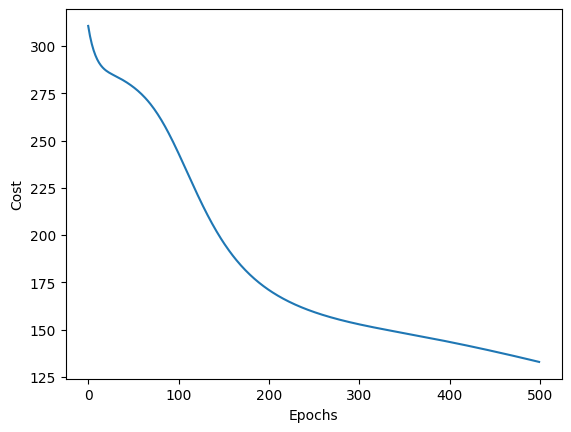

In [ ]:
# Cost-Epochs 그래프 그리기
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

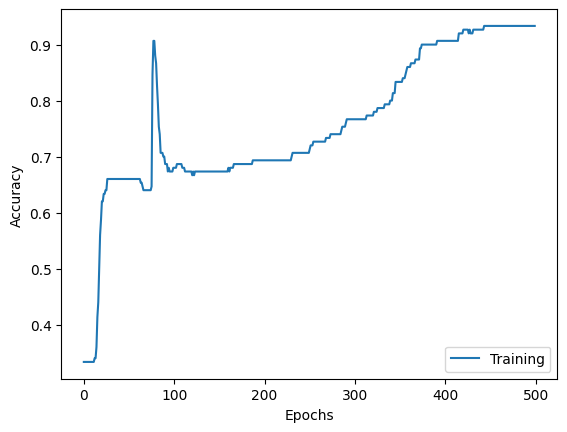

In [ ]:
# Train Accuracy-Epochs 그래프 그리기
plt.plot(range(nn.epochs), nn.eval_['train_acc'],
         label='Training')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

# 결정 경계 그래프 함수 정의
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # 마커와 컬러맵을 설정합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # 꽃받침 길이 최소/최대
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # 꽃잎 길이 최소/최대
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = (classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T))
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor=None if idx==1 else 'black')

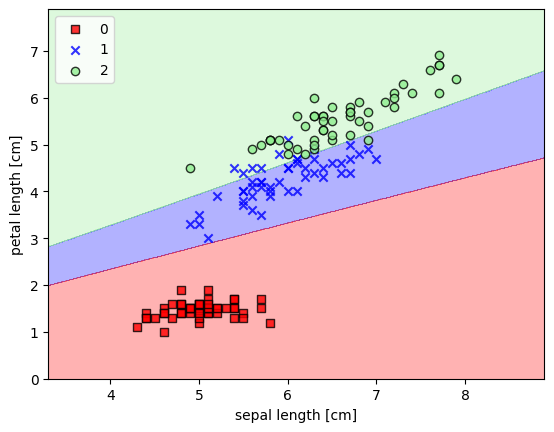

In [ ]:
# 결정 경계 그래프 출력
plot_decision_regions(X, y, classifier=nn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()